# Agent-Based Model - Schelling's Model of Racial Segregation
The method used in this notebook is copyrighted by Allen Downey 2016, MIT Licence.

Based on this method, this notebook is created by Michelle Hadiwiryo for Computational Modelling's project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/Cell2D.py')

# These files are referenced from Allen Downey's ThinkComplexity from github.

In [3]:
from utils import decorate, savefig
# make a directory for figures
!mkdir -p figs

In [4]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [5]:
# method to find cells at a given condition, returns a list of tuples
def cell_locs(condition):
    return list(zip(*np.nonzero(condition)))

This project simulates the interaction of three agents, creating a world where there are segregated patches:

In [6]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# make a custom color map
palette = sns.color_palette('muted')
colors = 'white', palette[1], palette[0], palette[2]
cmap = LinearSegmentedColormap.from_list('cmap', colors)

The illustration of a world with three segregated patches, assuming there is no empty spaces:

In [7]:
from Cell2D import Cell2D, draw_array
import random

# Class to simulate three segregated patches

class Segregated_patches(Cell2D):
    
    def __init__(self, n):
        """Initialise the attributes.
        n: number of rows
        """
        data = []
        divisor = n//3
        count = 0
        for i in range(n):
            data.append([1]*divisor + [random.choice([1,2])] + [2]*divisor + [random.choice([2,3])] + [3]*divisor)
        self.array = np.array(data)
    
    def draw(self):
        """Draw the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

Saving figure to file figs/ProjectFigure_01


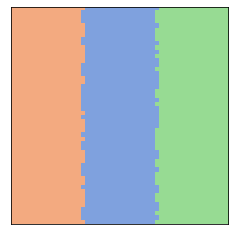

In [8]:
grid = Segregated_patches(n=50)
grid.draw()
savefig('figs/ProjectFigure_01')

Schelling's model of racial segregation:

In [9]:
from scipy.signal import correlate2d

class Schelling_segregation(Cell2D):
    """a representation of agents of residential segregation."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p, w, r, b, g):
        """Initialise the attributes.

        n: number of rows
        p: threshold on tolerant state ('happy' state)
        """
        self.p = p
        # initialise the community, where 0 is empty, 1 is red, 2 is blue, 3 is green
        community = np.array([0, 1, 2, 3], dtype=np.int8)
        # with the respective ratio
        ratio = [w, r, b, g]
        self.array = np.random.choice(community, (n, n), p=ratio)

    def community_ratio(self):
        """examine the ratio of the agents in the community .
        
        returns: tuple of
            empty: True where cells are empty
            fragment_red: fragments of red neighbors around each cell
            fragment_blue: fragments of blue neighbors around each cell
            fragment_green: fragments of green neighbors around each cell
            fragment_same: fragments of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2
        green = a==3

        # count the number of red, blue and green in total
        population_red = correlate2d(red, self.kernel, **self.options)
        population_blue = correlate2d(blue, self.kernel, **self.options)
        population_green = correlate2d(green, self.kernel, **self.options)
        total_community = population_red + population_blue + population_green
        total_community[total_community==0]=1

        # calculate the fragments of similar neighbors in the community
        fragment_red = population_red / total_community
        fragment_blue = population_blue / total_community
        fragment_green = population_green / total_community
        
        # no neighbors is considered the same as no similar neighbors
        fragment_red[total_community == 0] = 0
        fragment_blue[total_community == 0] = 0
        fragment_green[total_community == 0] = 0
        
        # for each cell, compute the fragment of neighbors with the same color
        fragment_samecolor = np.where(fragment_red, fragment_blue, fragment_green)

        # fragment of the same color is NaN for an empty cell
        fragment_samecolor[empty] = np.nan
        
        return empty, fragment_red, fragment_blue, fragment_green, fragment_samecolor

    def average_frag(self):
        # The average fragments of same neighbors
        _, _, _, _, fragment_samecolor = self.community_ratio()
        return np.nanmean(fragment_samecolor)
    
    def step(self):
        #Execute one time step.
        
        a = self.array
        empty, _, _, _, fragment_samecolor = self.community_ratio()
    
        # seek for the intolerant agent (ignore NaN in fragment_samecolor)
        with np.errstate(invalid='ignore'):
            intolerant = fragment_samecolor < self.p
        intolerant_agent = cell_locs(intolerant)
        
        # seek for the empty cells
        empty_locs = cell_locs(empty)

        # shuffle the intolerant agent
        if len(intolerant_agent):
            np.random.shuffle(intolerant_agent)
            
        # pick a random cell for an intolerant agent
        num_empty = np.sum(empty)
        
        for home in intolerant_agent:
            i = np.random.randint(num_empty)
            destination = empty_locs[i]
            
            # migrate to a new cell, while emptying the old cell
            a[destination] = a[home]
            a[home] = 0
            empty_locs[i] = home
        
            # unchanged number of the cell
            num_empty2 = np.sum(a==0)
            assert num_empty == num_empty2
        
        # the average fragments of same neighbors is returned
        return np.nanmean(fragment_samecolor)
        
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

Saving figure to file figs/ProjectFigure_02


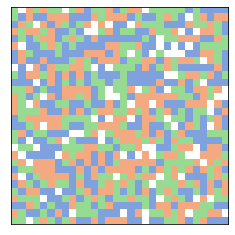

In [10]:
# Three agents living with the same ratio numbers
grid = Schelling_segregation(n=30, p=0.3, w=0.1, r=0.3, b=0.3, g=0.3)
grid.draw()
grid.average_frag()
savefig('figs/ProjectFigure_02')

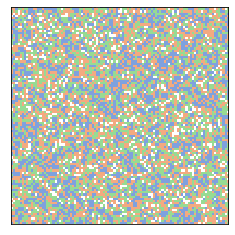

In [11]:
grid = Schelling_segregation(n=100, p=0.3, w=0.1, r=0.3, b=0.3, g=0.3)
grid.animate(frames=50, interval=0.1)

The difference between the state of the world in three different timeframes:

Saving figure to file figs/ProjectFigure_03


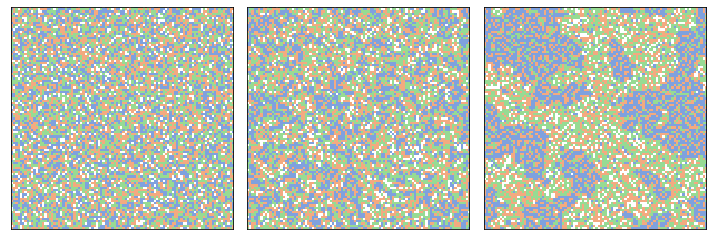

In [12]:
from utils import three_frame

grid = Schelling_segregation(n=100, p=0.3, w=0.1, r=0.3, b=0.3, g=0.3)
three_frame(grid, [0, 50, 2000])

savefig('figs/ProjectFigure_03')

A relation between segregation and timesteps needed are shown below:

0.2 0.34547263918924653 0.14547263918924652
0.3 0.3624149281261926 0.06241492812619259
0.7 0.32968072095438417 -0.3703192790456158
Saving figure to file figs/ProjectFigure_04


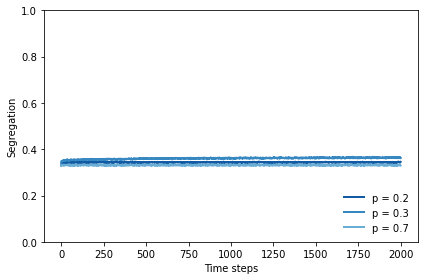

In [13]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

np.random.seed(17)
for p in [0.2, 0.3, 0.7]:
    grid = Schelling_segregation(n=100, p=p,  w=0.1, r=0.3, b=0.3, g=0.3)
    segs = [grid.step() for i in range(2000)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

savefig('figs/ProjectFigure_04')

In comparison with two agents from Schelling's model:

In [14]:
class Schelling_two(Cell2D):
    """a representation of agents of residential segregation."""
    
    options = dict(mode='same', boundary='wrap')

    kernel = np.array([[1, 1, 1],
                       [1, 0, 1],
                       [1, 1, 1]], dtype=np.int8)
    
    def __init__(self, n, p, w, r, b):
        """Initialise the attributes.

        n: number of rows
        p: threshold on tolerant state ('happy' state)
        """
        self.p = p
        # initialise the community, where 0 is empty, 1 is red, 2 is blue, 3 is green
        community = np.array([0, 1, 2], dtype=np.int8)
        # with the respective ratio
        ratio = [w, r, b]
        self.array = np.random.choice(community, (n, n), p=ratio)

    def community_ratio(self):
        """examine the ratio of the agents in the community .
        
        returns: tuple of
            empty: True where cells are empty
            fragment_red: fragments of red neighbors around each cell
            fragment_blue: fragments of blue neighbors around each cell
            fragment_same: fragments of neighbors with the same color
        """
        a = self.array
        
        empty = a==0
        red = a==1
        blue = a==2

        # count the number of red, blue and green in total
        population_red = correlate2d(red, self.kernel, **self.options)
        population_blue = correlate2d(blue, self.kernel, **self.options)
        total_community = population_red + population_blue
        total_community[total_community==0]=1

        # calculate the fragments of similar neighbors in the community
        fragment_red = population_red / total_community
        fragment_blue = population_blue / total_community
        
        # no neighbors is considered the same as no similar neighbors
        fragment_red[total_community == 0] = 0
        fragment_blue[total_community == 0] = 0
        
        # for each cell, compute the fragment of neighbors with the same color
        fragment_samecolor = np.where(red, fragment_red, fragment_blue)

        # fragment of the same color is NaN for an empty cell
        fragment_samecolor[empty] = np.nan
        
        return empty, fragment_red, fragment_blue, fragment_samecolor

    def average_frag(self):
        # The average fragments of same neighbors
        _, _, _,  fragment_samecolor = self.community_ratio()
        return np.nanmean(fragment_samecolor)
    
    def step(self):
        #Execute one time step.
        
        a = self.array
        empty, _, _, fragment_samecolor = self.community_ratio()
    
        # seek for the intolerant agent (ignore NaN in fragment_samecolor)
        with np.errstate(invalid='ignore'):
            intolerant = fragment_samecolor < self.p
        intolerant_agent = cell_locs(intolerant)
        
        # seek for the empty cells
        empty_locs = cell_locs(empty)

        # shuffle the intolerant agent
        if len(intolerant_agent):
            np.random.shuffle(intolerant_agent)
            
        # pick a random cell for an intolerant agent
        num_empty = np.sum(empty)
        
        for home in intolerant_agent:
            i = np.random.randint(num_empty)
            destination = empty_locs[i]
            
            # migrate to a new cell, while emptying the old cell
            a[destination] = a[home]
            a[home] = 0
            empty_locs[i] = home
        
            # unchanged number of the cell
            num_empty2 = np.sum(a==0)
            assert num_empty == num_empty2
        
        # the average fragments of same neighbors is returned
        return np.nanmean(fragment_samecolor)
        
    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=2)

With two agents, there are fewer time steps required to achieve a 'happy' or tolerant state:

Saving figure to file figs/ProjectFigure_05


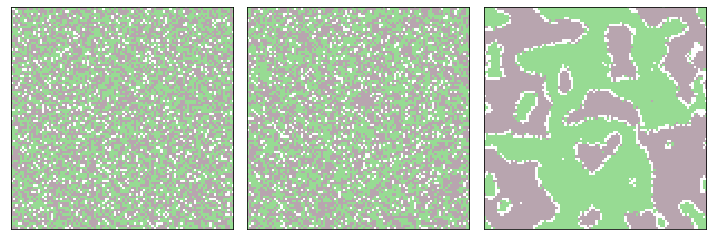

In [15]:
# Two agents living with the same ratio numbers

grid = Schelling_two(n=100, p=0.7, w=0.1, r=0.45, b=0.45)
three_frame(grid, [0, 2, 50])

savefig('figs/ProjectFigure_05')

A relation between segregation and timesteps needed are shown below:

0.2 0.5767376128991222 0.37673761289912217
0.3 0.7425316240947504 0.4425316240947504
0.7 0.9592606460384734 0.25926064603847343
Saving figure to file figs/ProjectFigure_06


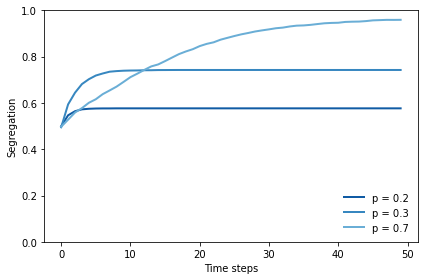

In [16]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

np.random.seed(17)
for p in [0.2, 0.3, 0.7]:
    grid = Schelling_two(n=100, p=p,  w=0.1, r=0.45, b=0.45)
    segs = [grid.step() for i in range(50)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

savefig('figs/ProjectFigure_06')

A simulation on a world with less population:

Saving figure to file figs/ProjectFigure_07


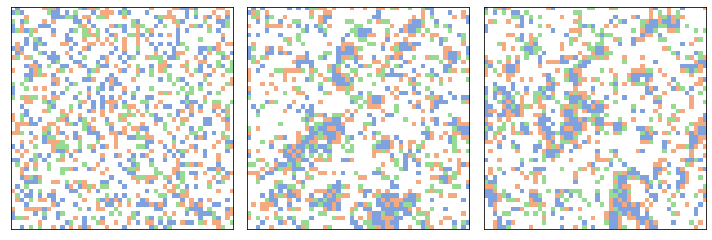

In [17]:
# Creating a world with more empty cells than the occupied cells by three kinds of agents
grid = Schelling_segregation(n=50, p=0.3, w=0.6, r=0.15, b=0.15, g=0.1)
three_frame(grid, [0, 50, 100])

savefig('figs/ProjectFigure_07')

It can be seen that 'unhappy' or 'intolerant' agents are able to find happiness on new cells more easily, as there are more available empty cells to choose. Fewer timesteps are taken in this less-populated world.

0.2 0.44551806888763407 0.24551806888763406
0.3 0.39052323056882327 0.09052323056882328
0.7 0.3191540843979868 -0.38084591560201314
Saving figure to file figs/ProjectFigure_08


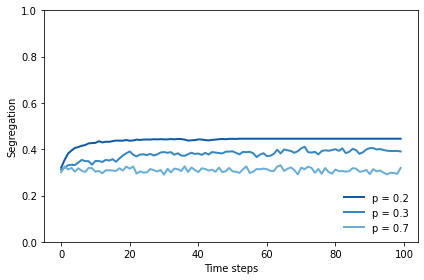

In [18]:
from utils import set_palette
set_palette('Blues', 5, reverse=True)

np.random.seed(17)
for p in [0.2, 0.3, 0.7]:
    grid = Schelling_segregation(n=50, p=p, w=0.6, r=0.15, b=0.15, g=0.1)
    segs = [grid.step() for i in range(100)]
    plt.plot(segs, label='p = %.1f' % p)
    print(p, segs[-1], segs[-1] - p)
    
decorate(xlabel='Time steps', ylabel='Segregation',
                loc='lower right', ylim=[0, 1])

savefig('figs/ProjectFigure_08')

Lower threshold level is needed to reach higher segregation level

A simulation of a world where there are low number of empty cells:

Saving figure to file figs/ProjectFigure_09


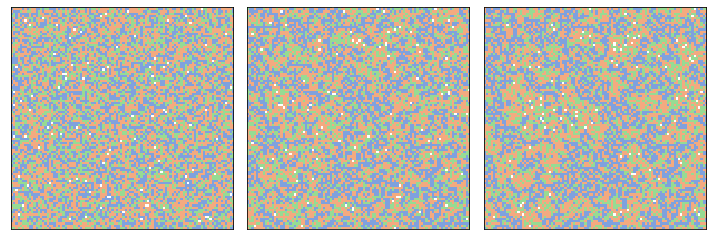

In [19]:
# Creating a populated world, where there is only 1% empty cells and 99% occupied cells
grid = Schelling_segregation(n=100, p=0.3, w=0.01, r=0.39, b=0.35, g=0.25)
three_frame(grid, [0, 50, 100])
#grid.animate(frames=100, interval=0.1)

savefig('figs/ProjectFigure_09')

The low number of empty cells available make the 'unhappy' agents unable to find the 'happy' state. This simulation reaches some level of segregation, however, 'unhappy' agents are unable to stop moving.

# A simulation using real-world data by the Australian Bureau of Statistics

The simulation of the number of population in Western Australia 2021, based on the census of population and housing conducted by the Australian Bureau of Statistics, as follows:

In [20]:
# Import the data for the number of different ethnicities according to the continent in Western Australia
import pandas as pd
data = pd.read_csv(r'/Users/michellehadiwiryo/Downloads/UWA/agentbasedsegregation/data2021.csv')
df = pd.DataFrame(data, columns=['continent', 'population'])
df['ratio'] = (df['population'] / df['population'].sum()) 

Saving figure to file figs/ProjectFigure_10


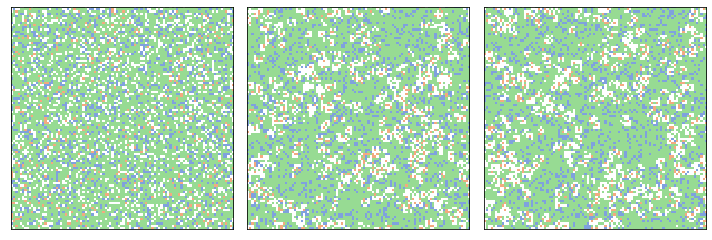

In [21]:
# assign the values. r is for the number of ethnicity from Africa, b is from Asia, g is from Europe
grid = Schelling_segregation(n=100, p=0.3, w=df._get_value(3,'ratio'), 
                             r=df._get_value(2,'ratio'), b=df._get_value(1,'ratio'), 
                             g=df._get_value(0,'ratio'))
three_frame(grid, [0, 50, 100])
#grid.animate(frames=100, interval=0.1)

savefig('figs/ProjectFigure_10')

When being put in a random position at time step 0, Europe Ethnicity although dominant (green) is still mixed. At time step 50 and 100, all agents form segregation, tightly positioning themselves with their own kinds.